In [6]:
import pandas as pd 
import psycopg2
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Load mode
load_mode = 'csv' #csv or db
csv_filename = 'historian_v1.csv'

In [8]:
if load_mode == 'db':
    conn = psycopg2.connect(
        dbname="historian",
        user ="postgres",
        password="yS5w162oCw",
        host="localhost",
        port="5432"
    )
    query = """ 
    select 
        time, run_id, category , category_sub , 
        data->'skill' as skill_name, 
        data->'episode_number' as episode,
        data->'obs' as obs,
        data->'reward' as reward,
        data->'raw_action' as action
    from public.events 
    where category in ('base-skill-env','teacher') and category_sub  in ('step','compute-reward')
    order by time 
    """

    df = pd.read_sql(query, conn)

elif load_mode == 'csv':
    df = pd.read_csv(csv_filemane)

/var/folders/y5/33d737hn3cg69hxsxbhhh0l80000gn/T/ipykernel_16110/211884267.py:15: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


In [10]:
df

,time,run_id,category,category_sub,skill_name,episode,obs,reward,action
0,2023-10-26 16:09:53.260000+00:00,c8d22af2-3dd2-449e-bfcb-002af3a6dd32,base-skill-env,step,None,NaN,None,NaN,None
1,2023-10-26 16:09:53.270000+00:00,c8d22af2-3dd2-449e-bfcb-002af3a6dd32,teacher,compute-reward,None,NaN,"{'T': 310.42869614487523, 'Ca': 8.585198651643...",0.000000,[-1.2275837659835815]
2,2023-10-26 16:09:53.270000+00:00,c8d22af2-3dd2-449e-bfcb-002af3a6dd32,base-skill-env,step,reaction,2.0,None,NaN,None
3,2023-10-26 16:09:53.400000+00:00,c8d22af2-3dd2-449e-bfcb-002af3a6dd32,base-skill-env,step,reaction,2.0,None,NaN,None
4,2023-10-26 16:09:53.400000+00:00,c8d22af2-3dd2-449e-bfcb-002af3a6dd32,base-skill-env,step,reaction,2.0,None,NaN,None
...,...,...,...,...,...,...,...,...,...
2935130,2023-10-26 17:07:24.461000+00:00,5be5d2e6-1d31-4be9-bb82-025b8061bef9,base-skill-env,step,reaction,202.0,None,NaN,None
2935131,2023-10-26 17:07:24.461000+00:00,5be5d2e6-1d31-4be9-bb82-025b8061bef9,teacher,compute-reward,None,NaN,"{'T': 402.3078712629084, 'Ca': 0.7273631029983...",0.526939,[0.00017070770263671875]
2935132,2023-10-26 17:07:24.461000+00:00,5be5d2e6-1d31-4be9-bb82-025b8061bef9,base-skill-env,step,reaction,202.0,None,NaN,None
2935133,2023-10-26 17:07:24.461000+00:00,5be5d2e6-1d31-4be9-bb82-025b8061bef9,base-skill-env,step,reaction,202.0,None,NaN,None


In [19]:
df[(df['run_id']=='c8d22af2-3dd2-449e-bfcb-002af3a6dd32') & (df['category']=='teacher') ]

,time,run_id,category,category_sub,skill_name,episode,obs,reward,action
1,2023-10-26 16:09:53.270000+00:00,c8d22af2-3dd2-449e-bfcb-002af3a6dd32,teacher,compute-reward,None,NaN,"{'T': 310.42869614487523, 'Ca': 8.585198651643...",0.000000,[-1.2275837659835815]
8,2023-10-26 16:10:02.356000+00:00,c8d22af2-3dd2-449e-bfcb-002af3a6dd32,teacher,compute-reward,reaction,2.0,"{'T': 310.42869614487523, 'Ca': 8.585198651643...",0.000000,[5.467321872711182]
16,2023-10-26 16:10:02.626000+00:00,c8d22af2-3dd2-449e-bfcb-002af3a6dd32,teacher,compute-reward,reaction,3.0,"{'T': 310.42869614487523, 'Ca': 8.585198651643...",0.000000,[-3.158571720123291]
25,2023-10-26 16:10:02.733000+00:00,c8d22af2-3dd2-449e-bfcb-002af3a6dd32,teacher,compute-reward,reaction,3.0,"{'T': 308.891087193425, 'Ca': 8.67071772127075...",12.285191,[3.8708982467651367]
28,2023-10-26 16:10:02.733000+00:00,c8d22af2-3dd2-449e-bfcb-002af3a6dd32,teacher,compute-reward,reaction,3.0,"{'T': 309.295815225561, 'Ca': 8.62574472623403...",17.938917,[3.7209901809692383]
...,...,...,...,...,...,...,...,...,...
9070,2023-10-26 16:12:16.532000+00:00,c8d22af2-3dd2-449e-bfcb-002af3a6dd32,teacher,compute-reward,reaction,17.0,"{'T': 310.4635482034926, 'Ca': 8.6448980317872...",1.130299,[-4.258301734924316]
9081,2023-10-26 16:12:16.640000+00:00,c8d22af2-3dd2-449e-bfcb-002af3a6dd32,teacher,compute-reward,reaction,17.0,"{'T': 309.5638101058453, 'Ca': 8.6540512343324...",1.087509,[4.593498229980469]
9088,2023-10-26 16:12:16.764000+00:00,c8d22af2-3dd2-449e-bfcb-002af3a6dd32,teacher,compute-reward,reaction,17.0,"{'T': 309.44905437382926, 'Ca': 8.673544175392...",1.042891,[-5.913298606872559]
9091,2023-10-26 16:12:16.787000+00:00,c8d22af2-3dd2-449e-bfcb-002af3a6dd32,teacher,compute-reward,reaction,17.0,"{'T': 308.5572166668238, 'Ca': 8.7012148068682...",0.997227,[-5.16330623626709]


In [110]:
c = 0
v = 0
iterations = []
for i,row in df.iterrows():
    if i > 0:
        if row['episode'] == v:
            c += 1
        else:
            c = 0
        v = row['episode']
    
    iterations.append(c)

df['iteration'] = iterations

In [114]:
df_group = df.groupby(['run_id','episode'])['reward'].mean()

#group by run_id and episode, with (min, mean, max) reward

In [117]:
df

,time,run_id,category,category_sub,skill_name,episode,obs,reward,action,iteration
0,2023-10-26 16:09:53.260000+00:00,c8d22af2-3dd2-449e-bfcb-002af3a6dd32,base-skill-env,step,None,NaN,None,NaN,None,0
1,2023-10-26 16:09:53.270000+00:00,c8d22af2-3dd2-449e-bfcb-002af3a6dd32,base-skill-env,step,reaction,2.0,None,NaN,None,0
2,2023-10-26 16:09:53.270000+00:00,c8d22af2-3dd2-449e-bfcb-002af3a6dd32,teacher,compute-reward,None,NaN,"{'T': 310.42869614487523, 'Ca': 8.585198651643...",0.0,[-1.2275837659835815],0
3,2023-10-26 16:09:53.400000+00:00,c8d22af2-3dd2-449e-bfcb-002af3a6dd32,base-skill-env,step,reaction,2.0,None,NaN,None,0
4,2023-10-26 16:09:53.400000+00:00,c8d22af2-3dd2-449e-bfcb-002af3a6dd32,base-skill-env,step,reaction,2.0,None,NaN,None,1
...,...,...,...,...,...,...,...,...,...,...
5861125,2023-10-26 21:49:28.831000+00:00,c3234f83-3bc9-41b4-b726-399a67da7bc6,base-skill-env,step,reaction,202.0,None,NaN,None,0
5861126,2023-10-26 21:49:28.832000+00:00,c3234f83-3bc9-41b4-b726-399a67da7bc6,base-skill-env,step,reaction,202.0,None,NaN,None,1
5861127,2023-10-26 21:49:28.832000+00:00,c3234f83-3bc9-41b4-b726-399a67da7bc6,base-skill-env,step,reaction,202.0,None,NaN,None,2
5861128,2023-10-26 21:49:28.832000+00:00,c3234f83-3bc9-41b4-b726-399a67da7bc6,base-skill-env,step,None,NaN,None,NaN,None,0


# Training Metrics

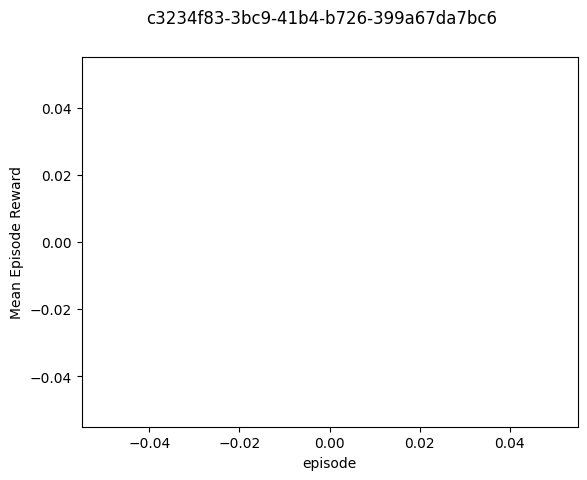

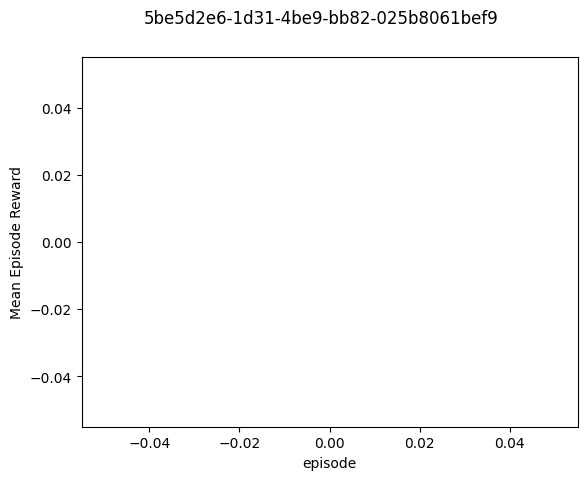

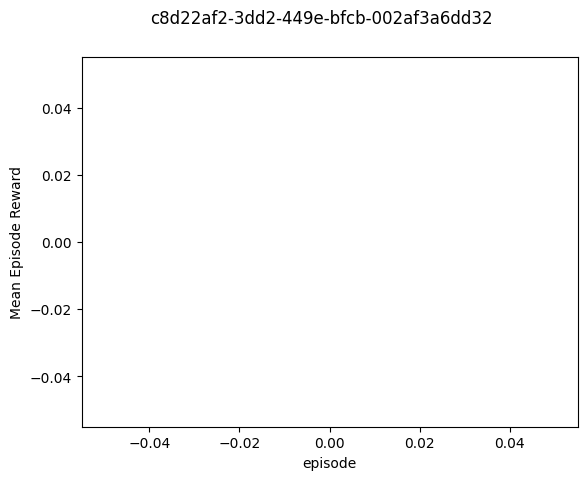

In [115]:
for run_id in list(set([x[0] for x in df_group.index])):
    df_group[run_id].plot(subplots=True, title=run_id)
    plt.ylabel('Mean Episode Reward')
    plt.show()

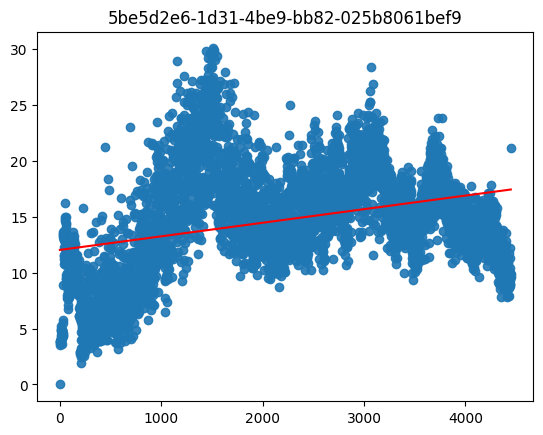

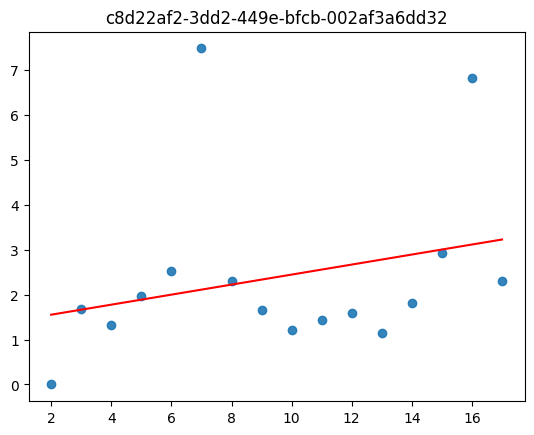

In [41]:
for run_id in list(set([x[0] for x in df_group.index])):
    plt.scatter(df_group[run_id].index, df_group[run_id].reset_index()['reward'], alpha=0.1)
    plt.title(run_id)
    if len(df_group[run_id]) > 10:
        slope, intercept = np.polyfit(df_group[run_id].index, df_group[run_id].reset_index()['reward'], 1)
        plt.plot(df_group[run_id].index, slope * df_group[run_id].index + intercept, 'r')
    #df_group[run_id].plot(kind='scatter',subplots=True, title=run_id)
    plt.show()

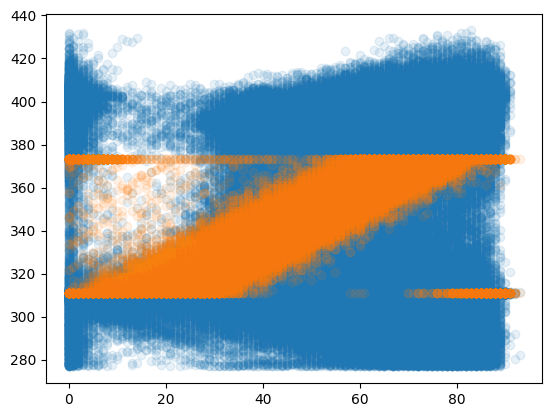

In [63]:
plt.scatter(df['iteration'], df['obs'].apply(lambda x: x['T']), alpha=0.1)
plt.scatter(df['iteration'], df['obs'].apply(lambda x: x['Tref']), alpha=0.1)

<Axes: >

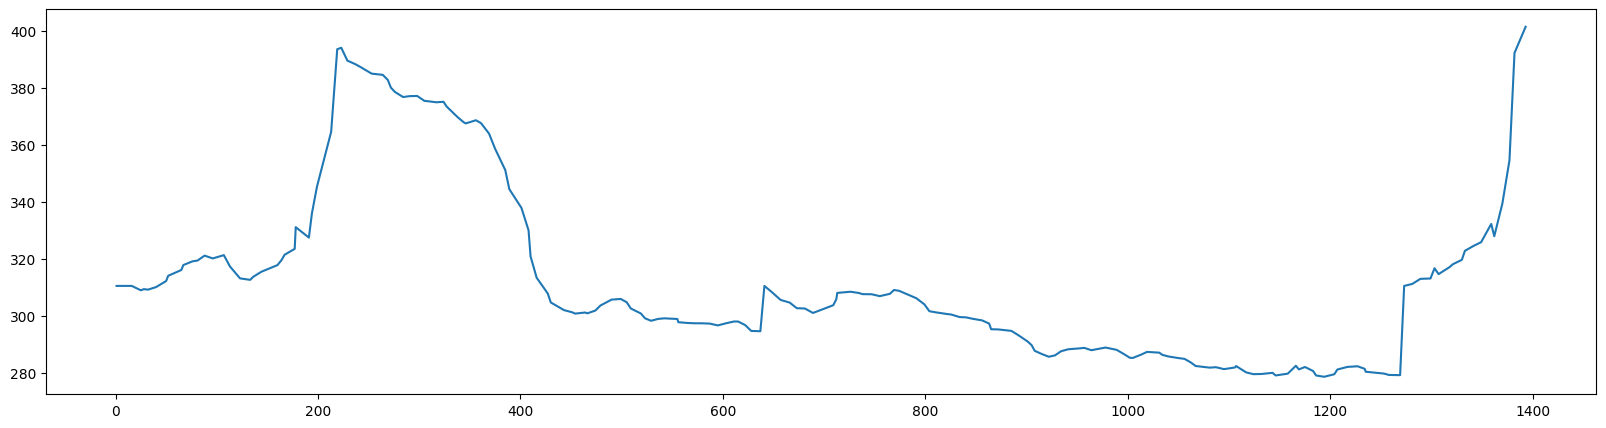

In [53]:
df['obs'].apply(lambda x: x['T'])[:200].plot(figsize=(20,5))

In [ ]:
plt.figure(figsize=(12,7))
plt.subplot(3,1,1)
#plt.plot(self.reward_history, 'r.-')
plt.plot(df.reset_index()['time'],df.reset_index()['Tc'])
plt.ylabel('Control Action - Tc')
plt.legend(['reward'],loc='best')

plt.subplot(3,1,2)
#plt.plot(self.rms_history, 'r.-')
plt.plot(df.reset_index()['time'],df.reset_index()['T'])
plt.plot(df.reset_index()['time'],df.reset_index()['Tref'],'r--')
plt.ylabel('Temp')
plt.legend(['T', 'Tref'],loc='best')

plt.subplot(3,1,3)
plt.plot(df.reset_index()['time'],df.reset_index()['Ca'])
plt.plot(df.reset_index()['time'],df.reset_index()['Cref'],'r--')
plt.legend(['Ca', 'Cref'],loc='best')
plt.ylabel('Concentration')
plt.xlabel('iteration')

In [16]:
df['episode'] = df.episode.ffill()
df['skill_name'] = df.skill_name.ffill()

In [17]:
df = df.dropna(subset=['obs'])

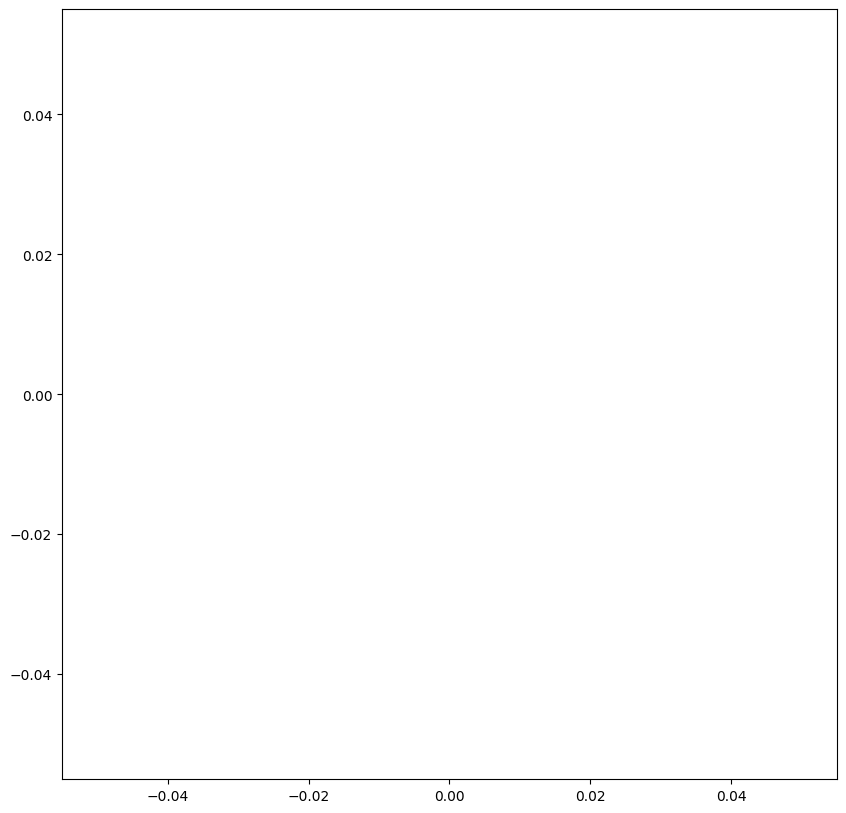

In [18]:
plt.figure(figsize=(10,10))
plt.scatter(df[df['run_id']=='6b102fdd-c0da-42b3-8632-4e44073e0e19']['episode'], df[df['run_id']=='6b102fdd-c0da-42b3-8632-4e44073e0e19']['reward'])
plt.show()

In [ ]:
conn.close()

In [79]:
#t1 = pd.DataFrame()
df_temp = pd.DataFrame(columns=['Ca','Cref'],data=[[3, 4]])

In [80]:
t1 = pd.concat([t1, df_temp])
t1

,Ca,Cref
0,1,2
0,3,4


In [84]:
t1.to_csv('test.csv', index=False)

In [85]:
t2 = pd.read_csv('test.csv')
t2

,Ca,Cref
0,1,2
1,3,4


In [72]:
t = pd.read_csv('../history.csv')
t

,Unnamed: 0.19,Unnamed: 0.18,Unnamed: 0.17,Unnamed: 0.16,Unnamed: 0.15,Unnamed: 0.14,Unnamed: 0.13,Unnamed: 0.12,Unnamed: 0.11,Unnamed: 0.10,...,Unnamed: 0.7,Unnamed: 0.6,Unnamed: 0.5,Unnamed: 0.4,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,Ca,Cref


# Analayze each run

In [103]:
run_id = '5be5d2e6-1d31-4be9-bb82-025b8061bef9'

In [106]:
print('Max Episode: ', df['episode'].max())
episode = 4447

Max Episode:  4447.0


In [107]:
#FILTER
df_filter = df[df['run_id'] == run_id]

In [108]:
df_filter[df['episode'] == episode]

/var/folders/y5/33d737hn3cg69hxsxbhhh0l80000gn/T/ipykernel_16110/620731692.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_filter[df['episode'] == episode]


,time,run_id,category,category_sub,skill_name,episode,obs,reward,action
2928544,2023-10-26 17:07:17.571000+00:00,5be5d2e6-1d31-4be9-bb82-025b8061bef9,base-skill-env,step,reaction,4447.0,None,NaN,None
2928545,2023-10-26 17:07:17.571000+00:00,5be5d2e6-1d31-4be9-bb82-025b8061bef9,base-skill-env,step,reaction,4447.0,None,NaN,None
2928546,2023-10-26 17:07:17.571000+00:00,5be5d2e6-1d31-4be9-bb82-025b8061bef9,base-skill-env,step,reaction,4447.0,None,NaN,None
2928547,2023-10-26 17:07:17.571000+00:00,5be5d2e6-1d31-4be9-bb82-025b8061bef9,base-skill-env,step,reaction,4447.0,None,NaN,None
2928548,2023-10-26 17:07:17.571000+00:00,5be5d2e6-1d31-4be9-bb82-025b8061bef9,base-skill-env,step,reaction,4447.0,None,NaN,None
...,...,...,...,...,...,...,...,...,...
2928829,2023-10-26 17:07:17.892000+00:00,5be5d2e6-1d31-4be9-bb82-025b8061bef9,base-skill-env,step,reaction,4447.0,None,NaN,None
2928830,2023-10-26 17:07:17.892000+00:00,5be5d2e6-1d31-4be9-bb82-025b8061bef9,base-skill-env,step,reaction,4447.0,None,NaN,None
2928831,2023-10-26 17:07:17.892000+00:00,5be5d2e6-1d31-4be9-bb82-025b8061bef9,base-skill-env,step,reaction,4447.0,None,NaN,None
2928832,2023-10-26 17:07:17.892000+00:00,5be5d2e6-1d31-4be9-bb82-025b8061bef9,base-skill-env,step,reaction,4447.0,None,NaN,None


In [109]:
#plt.scatter(df_filter[df['episode'] == episode]['time'][:88],df_filter[df['episode'] == episode].reset_index()['obs'].apply(lambda x: x['T'])[:88])
plt.plot(df_filter[df['episode'] == episode]['iteration'][:88],df_filter[df['episode'] == episode].reset_index()['obs'].apply(lambda x: x['Tref'])[:88])

/var/folders/y5/33d737hn3cg69hxsxbhhh0l80000gn/T/ipykernel_16110/2696221139.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.plot(df_filter[df['episode'] == episode]['iteration'][:88],df_filter[df['episode'] == episode].reset_index()['obs'].apply(lambda x: x['Tref'])[:88])


KeyError: 'iteration'

/var/folders/y5/33d737hn3cg69hxsxbhhh0l80000gn/T/ipykernel_16110/379643222.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.scatter(df_filter[df['episode'] == episode]['iteration'], df_filter[df['episode'] == episode]['obs'].apply(lambda x: x['T']), alpha=0.9)
/var/folders/y5/33d737hn3cg69hxsxbhhh0l80000gn/T/ipykernel_16110/379643222.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.scatter(df_filter[df['episode'] == episode]['iteration'], df_filter[df['episode'] == episode]['obs'].apply(lambda x: x['T']), alpha=0.9)
/var/folders/y5/33d737hn3cg69hxsxbhhh0l80000gn/T/ipykernel_16110/379643222.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.scatter(df_filter[df['episode'] == episode]['iteration'], df_filter[df['episode'] == episode]['obs'].apply(lambda x: x['Tref']), alpha=0.9)
/var/folders/y5/33d737hn3cg69hxsxbhhh0l80000gn/T/ipykernel_16110/379643222.py:3: UserWarning: Boo

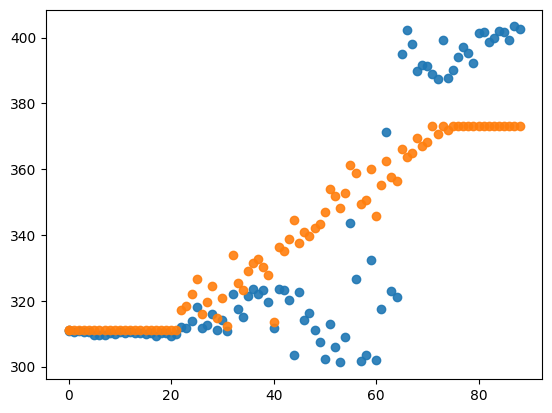

In [96]:
plt.scatter(df_filter[df['episode'] == episode]['iteration'], df_filter[df['episode'] == episode]['obs'].apply(lambda x: x['T']), alpha=0.9)
plt.scatter(df_filter[df['episode'] == episode]['iteration'], df_filter[df['episode'] == episode]['obs'].apply(lambda x: x['Tref']), alpha=0.9)

/var/folders/y5/33d737hn3cg69hxsxbhhh0l80000gn/T/ipykernel_16110/3172287909.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.scatter(df_filter[df['episode'] == episode]['obs'].apply(lambda x: x['Cref']), df_filter[df['episode'] == episode]['obs'].apply(lambda x: x['Ca']), alpha=0.4)
/var/folders/y5/33d737hn3cg69hxsxbhhh0l80000gn/T/ipykernel_16110/3172287909.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.scatter(df_filter[df['episode'] == episode]['obs'].apply(lambda x: x['Cref']), df_filter[df['episode'] == episode]['obs'].apply(lambda x: x['Ca']), alpha=0.4)


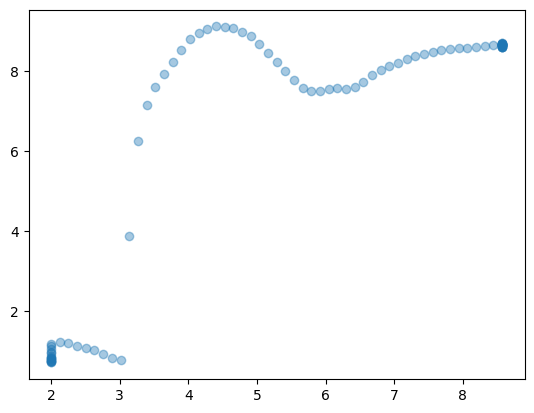

In [100]:
plt.scatter(df_filter[df['episode'] == episode]['obs'].apply(lambda x: x['Cref']), df_filter[df['episode'] == episode]['obs'].apply(lambda x: x['Ca']), alpha=0.4)

/var/folders/y5/33d737hn3cg69hxsxbhhh0l80000gn/T/ipykernel_16110/3100982370.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.scatter(df_filter[df['episode'] == episode]['obs'].apply(lambda x: x['Tref']), df_filter[df['episode'] == episode]['obs'].apply(lambda x: x['T']), alpha=0.4)
/var/folders/y5/33d737hn3cg69hxsxbhhh0l80000gn/T/ipykernel_16110/3100982370.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.scatter(df_filter[df['episode'] == episode]['obs'].apply(lambda x: x['Tref']), df_filter[df['episode'] == episode]['obs'].apply(lambda x: x['T']), alpha=0.4)


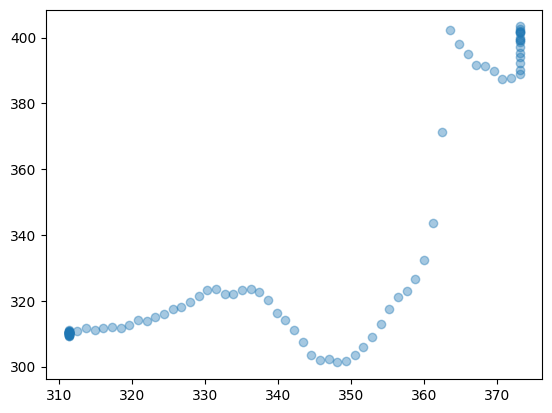

In [98]:
plt.scatter(df_filter[df['episode'] == episode]['obs'].apply(lambda x: x['Tref']), df_filter[df['episode'] == episode]['obs'].apply(lambda x: x['T']), alpha=0.4)

In [66]:
df_filter

,time,run_id,category,category_sub,skill_name,episode,obs,reward,action,iteration
9111,2023-10-26 16:13:47.159000+00:00,5be5d2e6-1d31-4be9-bb82-025b8061bef9,teacher,compute-reward,reaction,2.0,"{'T': 310.42869614487523, 'Ca': 8.585198651643...",0.000000,[0.31863608956336975],0
9116,2023-10-26 16:13:56.145000+00:00,5be5d2e6-1d31-4be9-bb82-025b8061bef9,teacher,compute-reward,reaction,2.0,"{'T': 310.42869614487523, 'Ca': 8.585198651643...",0.000000,[9.353528022766112],1
9124,2023-10-26 16:13:56.164000+00:00,5be5d2e6-1d31-4be9-bb82-025b8061bef9,teacher,compute-reward,reaction,3.0,"{'T': 308.3307059289836, 'Ca': 8.6931014825584...",11.152168,[-9.893667221069336],0
9132,2023-10-26 16:13:56.166000+00:00,5be5d2e6-1d31-4be9-bb82-025b8061bef9,teacher,compute-reward,reaction,3.0,"{'T': 306.1519441364481, 'Ca': 8.7648432614914...",8.026673,[-4.257821083068848],1
9146,2023-10-26 16:13:56.166000+00:00,5be5d2e6-1d31-4be9-bb82-025b8061bef9,teacher,compute-reward,reaction,3.0,"{'T': 309.4133510284074, 'Ca': 8.6516002646156...",14.934165,[-6.120590686798096],2
...,...,...,...,...,...,...,...,...,...,...
2935101,2023-10-26 17:07:24.460000+00:00,5be5d2e6-1d31-4be9-bb82-025b8061bef9,teacher,compute-reward,reaction,203.0,"{'T': 310.42869614487523, 'Ca': 8.585198651643...",0.000000,[9.094171524047852],0
2935103,2023-10-26 17:07:24.460000+00:00,5be5d2e6-1d31-4be9-bb82-025b8061bef9,teacher,compute-reward,reaction,202.0,"{'T': 402.3069485447887, 'Ca': 0.7273880263109...",0.523599,[0.0005283355712890625],0
2935107,2023-10-26 17:07:24.460000+00:00,5be5d2e6-1d31-4be9-bb82-025b8061bef9,teacher,compute-reward,reaction,202.0,"{'T': 402.30805828104366, 'Ca': 0.727358057928...",0.528575,[8.487701416015625e-05],1
2935124,2023-10-26 17:07:24.461000+00:00,5be5d2e6-1d31-4be9-bb82-025b8061bef9,teacher,compute-reward,reaction,202.0,"{'T': 402.3075401032663, 'Ca': 0.7273720587761...",0.525280,[0.00027561187744140625],2
